# Import Libraries & Installing Quandl [Step 1]

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# Import Dataset [Step 2]

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'suvDKGUy1XKncKixR-cK'

In [3]:
# Importing the Federal Reserve Economic Data "Effective Federal Funds Rate" variable.

data = quandl.get('FRED/DFF')

The DFF data set is the Effective Federal Funds Rate. According to the Federal Reserve Bank of New York, "The effective federal funds rate (EFFR) is calculated as a volume-weighted median of overnight federal funds transactions reported in the FR 2420 Report of Selected Money Market Rates," so basically, how much it costs to buy and sell stock on the stock exchange. How high or low the rate is would influence when people decide to buy, sell, or hold, which in turn affects how our stocks fluctuates. 

In [4]:
data.shape

(24852, 1)

In [5]:
data.columns

Index(['Value'], dtype='object')

In [6]:
data.head()

,Value
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


In [7]:
type(data)

pandas.core.frame.DataFrame

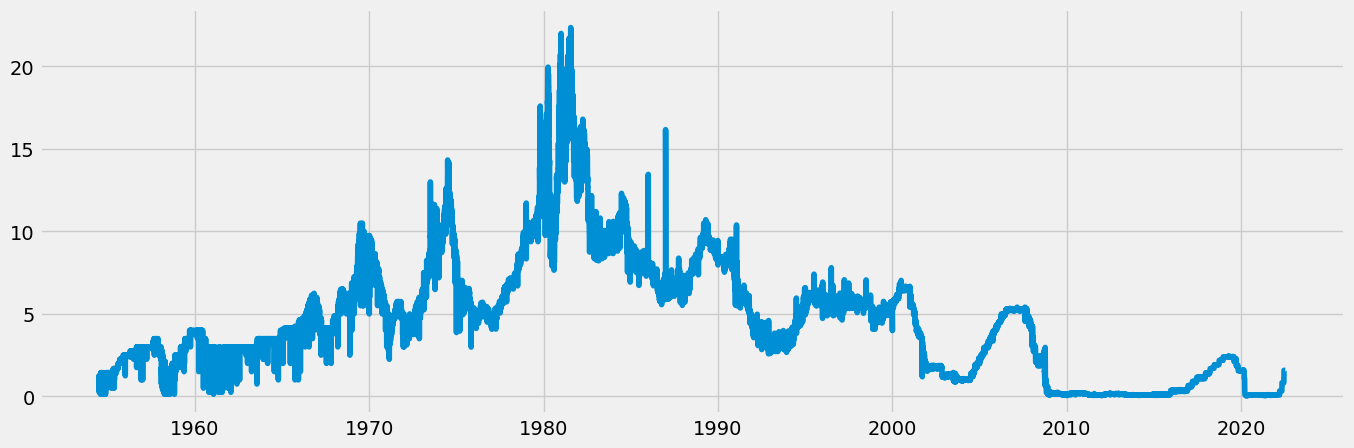

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

Interpretation: I Googled what "Effective Federal Fund Rates" meant and this was what was given: "The effective federal funds rate (EFFR) is calculated as a volume-weighted median of overnight federal funds transactions reported in the FR 2420 Report of Selected Money Market Rates." I'm not sure if I'm understanding this correctly, but since we had the financial crisis/market crash in the 1980s and it was during a time where the government was trying to combat inflation, it caused an influx in the rate of things. 

# Creating a Subset [Step 3]

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [12]:
data_sub.shape

(14762, 2)

In [13]:
data_sub.head()

,Date,Value
9315,1980-01-01,14.77
9316,1980-01-02,14.00
9317,1980-01-03,13.89
9318,1980-01-04,14.00
9319,1980-01-05,14.00


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,14.77
1980-01-02,14.00
1980-01-03,13.89
1980-01-04,14.00
1980-01-05,14.00


# Line Chart [Step 4]

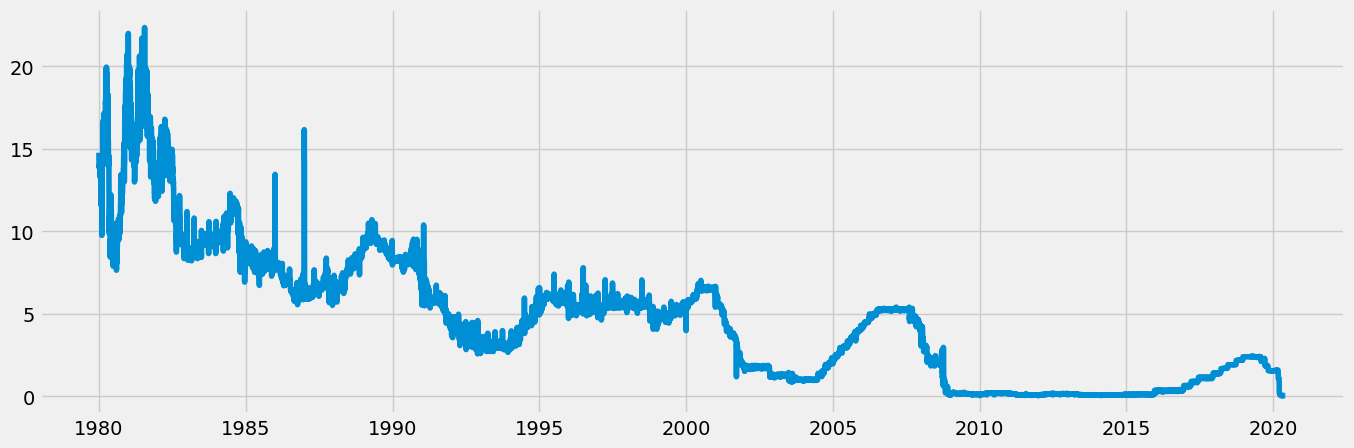

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

Interpretation: I believe we haven't had such a drastic spike again was due to the policies and regulations that were enacted after the uncertainties that were happening. We had other financial crisis and inflation issues afterwards, but they didn't spike as badly as in the 1980s. 

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

13302

# Decompose Data [Step 5]

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

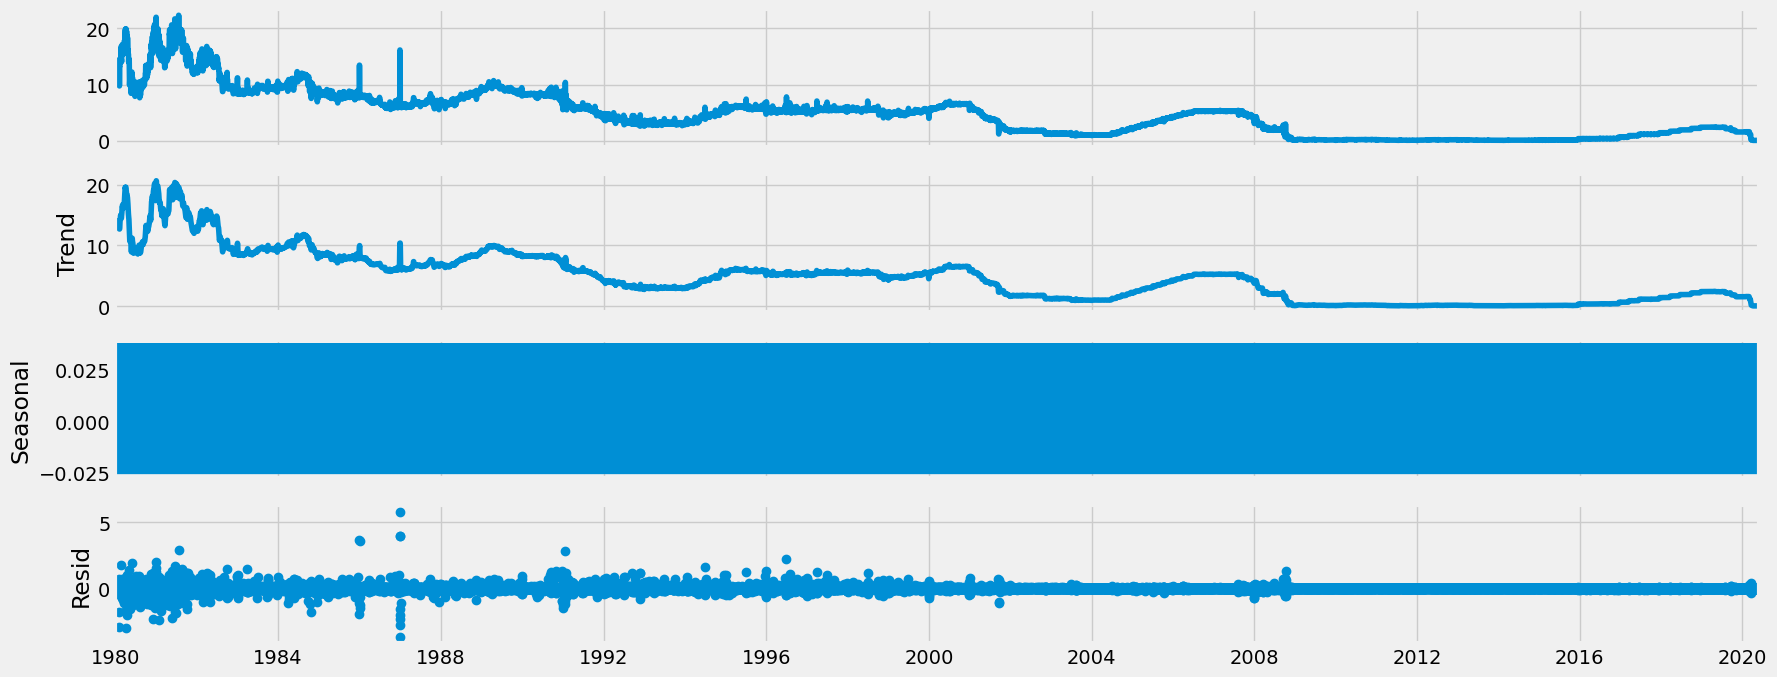

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

Interpretation: I'm actually not sure what to make of this, like, is there no seasonality with this dataset? That'd be weird given our financial, political, and economic climate, and how sporadic it can be sometimes, especially during election years. Though, I think the noise during the 1980s make sense as there were so many new policies and regulations being enacted to avoid another financial crisis, so it makes sense that it'd fluctuate a lot before it smooths out when people become accustom to the new climate. 

# Stationarity (Dickey-Fuller test) [Step 6]

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                    -2.505421
p-value                            0.114161
Number of Lags Used               42.000000
Number of Observations Used    14719.000000
Critical Value (1%)               -3.430794
Critical Value (5%)               -2.861736
Critical Value (10%)              -2.566875
dtype: float64


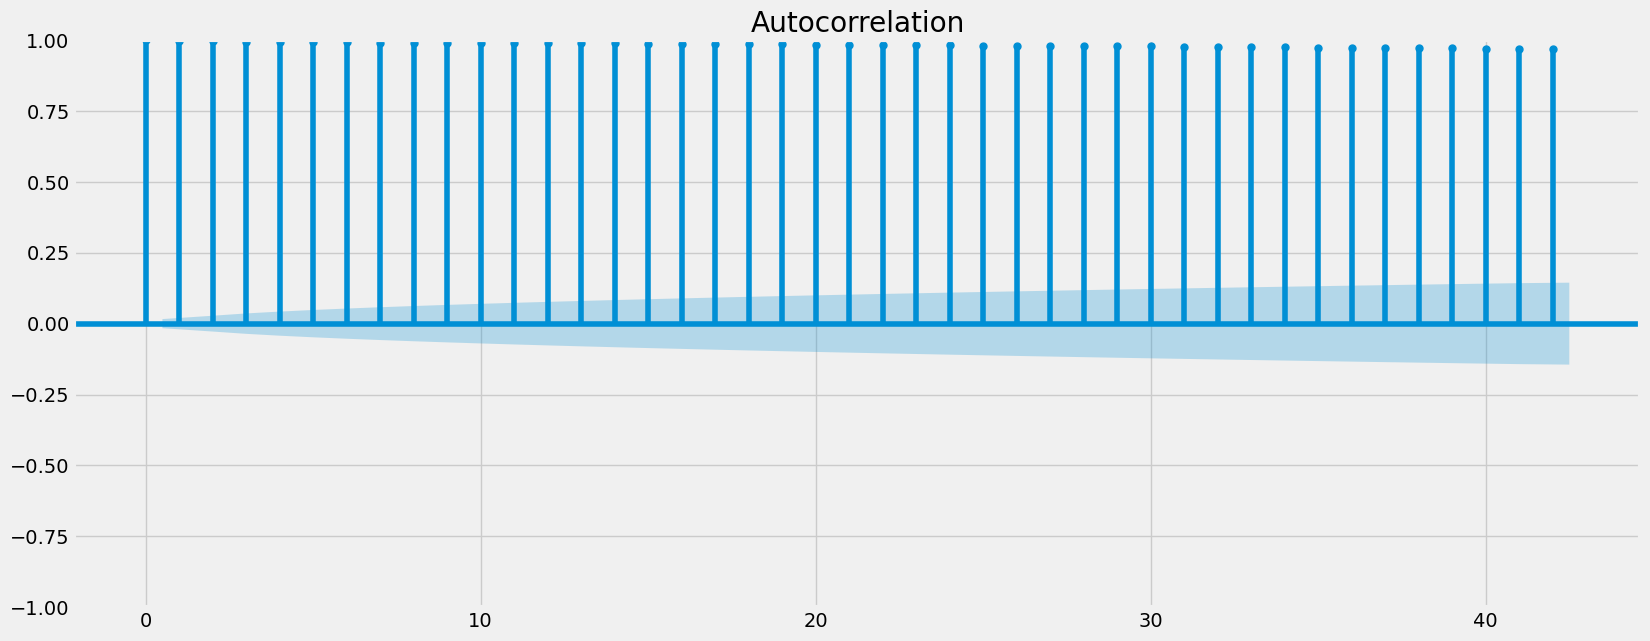

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

From the lesson: "When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that your data is non-stationary."

Based on that, the lags are not significantly correlated to each other because a lot of them are not within the blue area, and the data is likely stationary. 

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.columns

Index(['Value'], dtype='object')

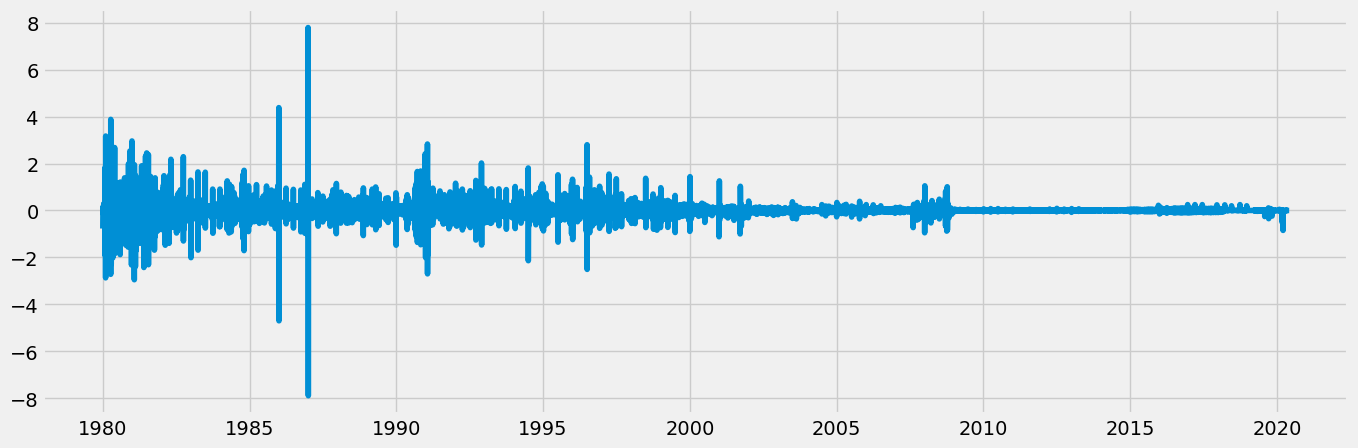

In [26]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.696793e+01
p-value                        9.204679e-30
Number of Lags Used            4.100000e+01
Number of Observations Used    1.471900e+04
Critical Value (1%)           -3.430794e+00
Critical Value (5%)           -2.861736e+00
Critical Value (10%)          -2.566875e+00
dtype: float64


Interpretation: Given how high our p-value is, the data is likely random with no significant correlation. 

# Data Autocorrelation [Step 9]

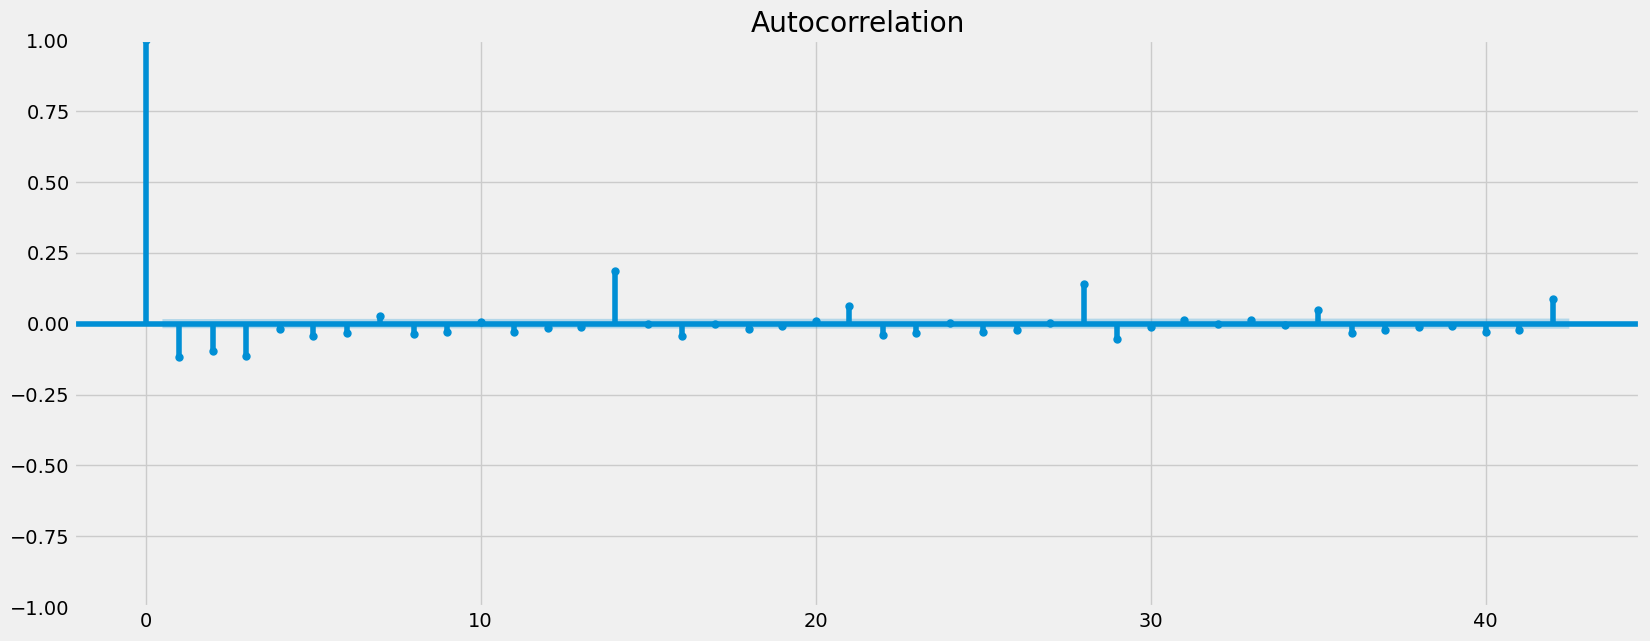

In [28]:
plot_acf(data_diff)
plt.show()

Interpretation: I don't even see a blue area in this, so I'm going to go with there not being any correlation at all with this data set. 